In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
df = pdr.get_data_fred('ICNSA')
df.head()

,ICNSA
DATE,
2019-03-02,220540
2019-03-09,209302
2019-03-16,194335
2019-03-23,190023
2019-03-30,183775


<Axes: xlabel='DATE'>

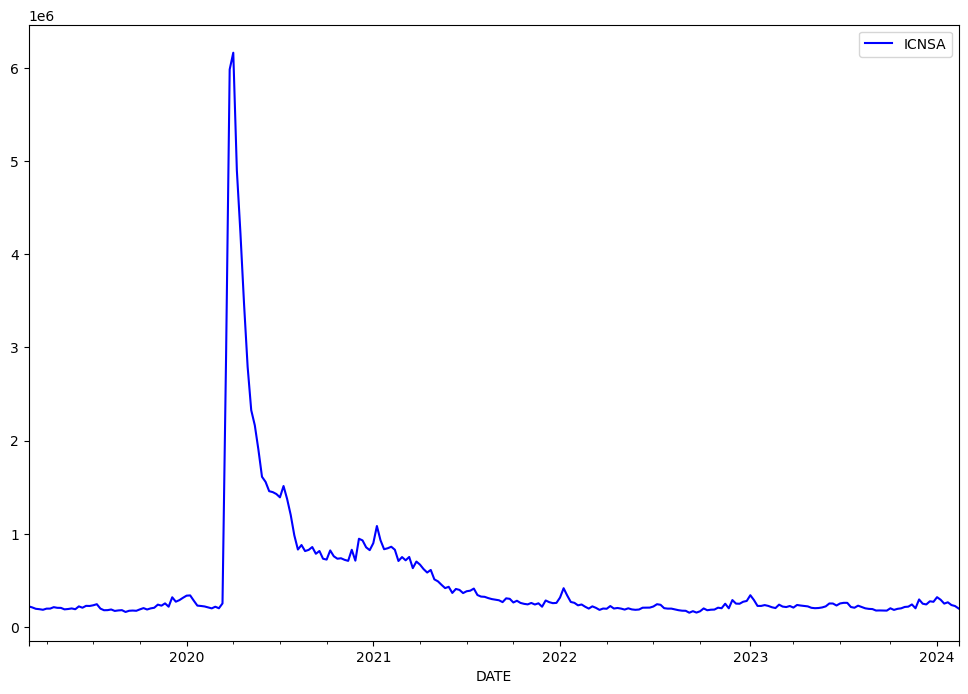

In [24]:
df.plot(figsize=(12,8),c='blue')

<Axes: xlabel='DATE'>

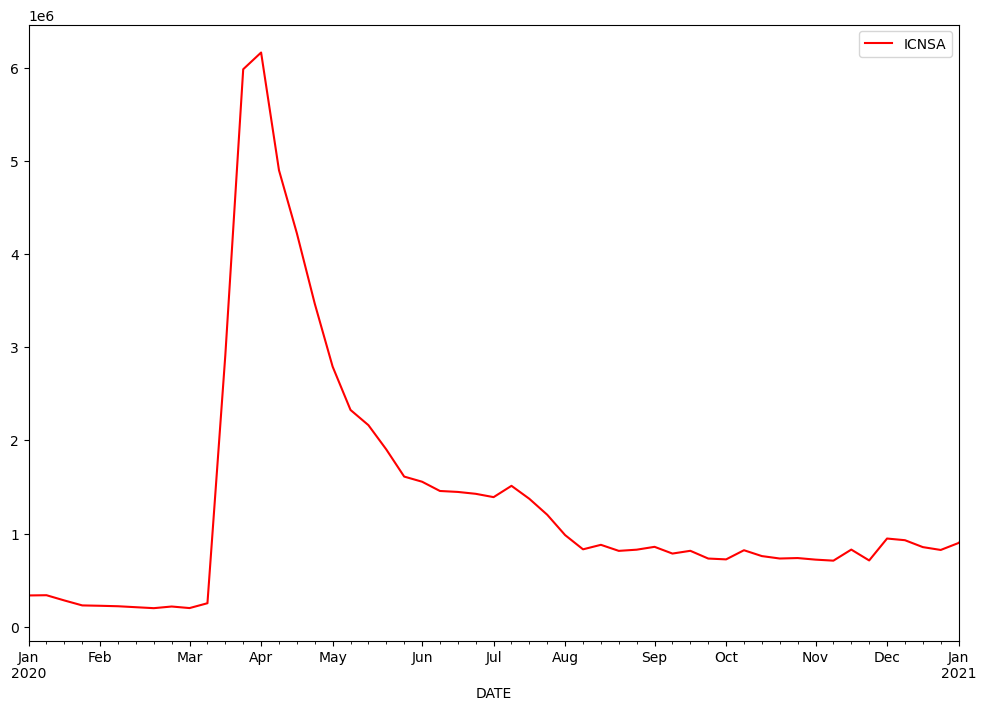

In [25]:
# let's extract and plot the covid pandemic claims
df.plot(xlim=['2020-01-01','2021-01-01'],figsize=(12,8),c='red')

In [26]:
# extracting the covid periods
df_covid = df.loc['2020-01-01':'2021-01-01']
df_covid.head()

,ICNSA
DATE,
2020-01-04,335294
2020-01-11,337883
2020-01-18,281646
2020-01-25,228443
2020-02-01,224561


In [27]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52 entries, 2020-01-04 to 2020-12-26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ICNSA   52 non-null     int64
dtypes: int64(1)
memory usage: 832.0 bytes


In [28]:
# this is a weekly data..let's change it to daily data
covid_daily = df_covid.resample('D').mean()
covid_daily.tail()

,ICNSA
DATE,
2020-12-22,NaN
2020-12-23,NaN
2020-12-24,NaN
2020-12-25,NaN
2020-12-26,823512.0


In [29]:
print(len(covid_daily))
print(covid_daily['ICNSA'].isnull().sum())

358
306


# Interpolating using Cubic Spline Methodology

In [30]:
from scipy.interpolate import CubicSpline

In [31]:
pd.isnull(covid_daily.loc['2020-12-24'].ICNSA)

True

Check where the values are present for interpolation

In [32]:
x = [i for i,col in enumerate(covid_daily.index) if not pd.isnull(covid_daily.loc[col].ICNSA)]
y = [covid_daily.loc[col].ICNSA for i,col in enumerate(covid_daily.index) if not pd.isnull(covid_daily.loc[col].ICNSA)]
print(x)
print(y)

[0, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84, 91, 98, 105, 112, 119, 126, 133, 140, 147, 154, 161, 168, 175, 182, 189, 196, 203, 210, 217, 224, 231, 238, 245, 252, 259, 266, 273, 280, 287, 294, 301, 308, 315, 322, 329, 336, 343, 350, 357]
[335294.0, 337883.0, 281646.0, 228443.0, 224561.0, 219459.0, 209218.0, 198845.0, 216625.0, 199914.0, 251875.0, 2914268.0, 5981838.0, 6161268.0, 4898119.0, 4221704.0, 3466665.0, 2790860.0, 2325889.0, 2162822.0, 1902006.0, 1610909.0, 1555824.0, 1456353.0, 1446176.0, 1425969.0, 1390315.0, 1511632.0, 1372247.0, 1200962.0, 982808.0, 830266.0, 878555.0, 813744.0, 826436.0, 857006.0, 784765.0, 814441.0, 731391.0, 722387.0, 820590.0, 757745.0, 731660.0, 736618.0, 719716.0, 708717.0, 827447.0, 710901.0, 946091.0, 928178.0, 854113.0, 823512.0]


In [33]:
cubic_interpolate = CubicSpline(x,y,bc_type='natural')
points=[i for i in range(len(covid_daily))]
covid_daily['Interpolated'] = cubic_interpolate(points)

<Axes: xlabel='DATE'>

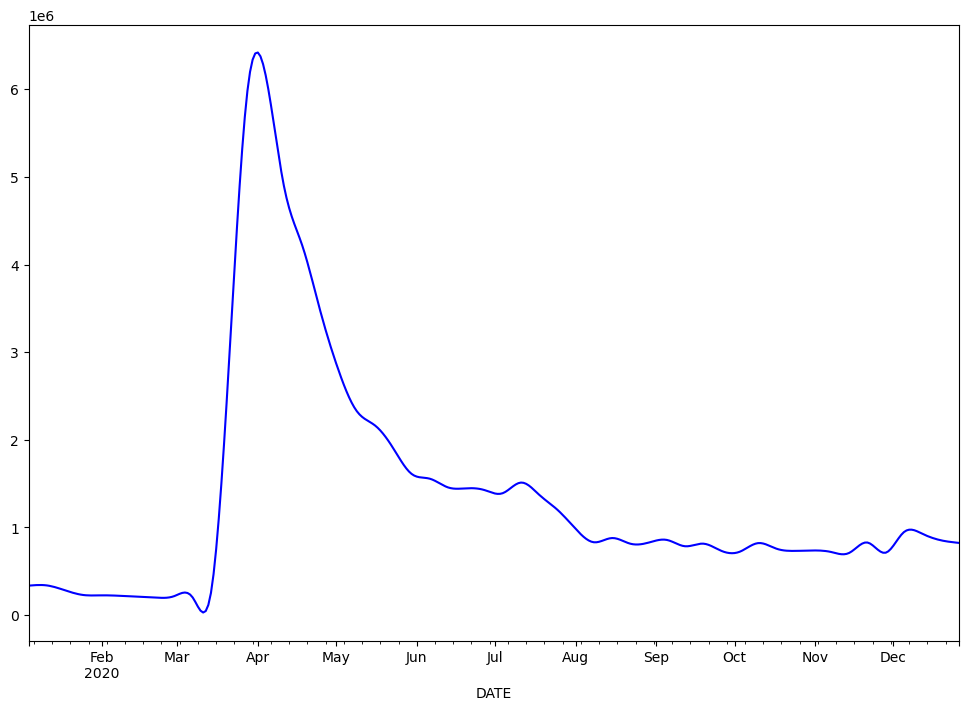

In [34]:
covid_daily['Interpolated'].plot(figsize=(12,8),c='blue')

In [35]:
covid_daily.head()

,ICNSA,Interpolated
DATE,,
2020-01-04,335294.0,335294.000000
2020-01-05,NaN,337767.513575
2020-01-06,NaN,339978.070096
2020-01-07,NaN,341662.712509
2020-01-08,NaN,342558.483760


Seasonal Decompose

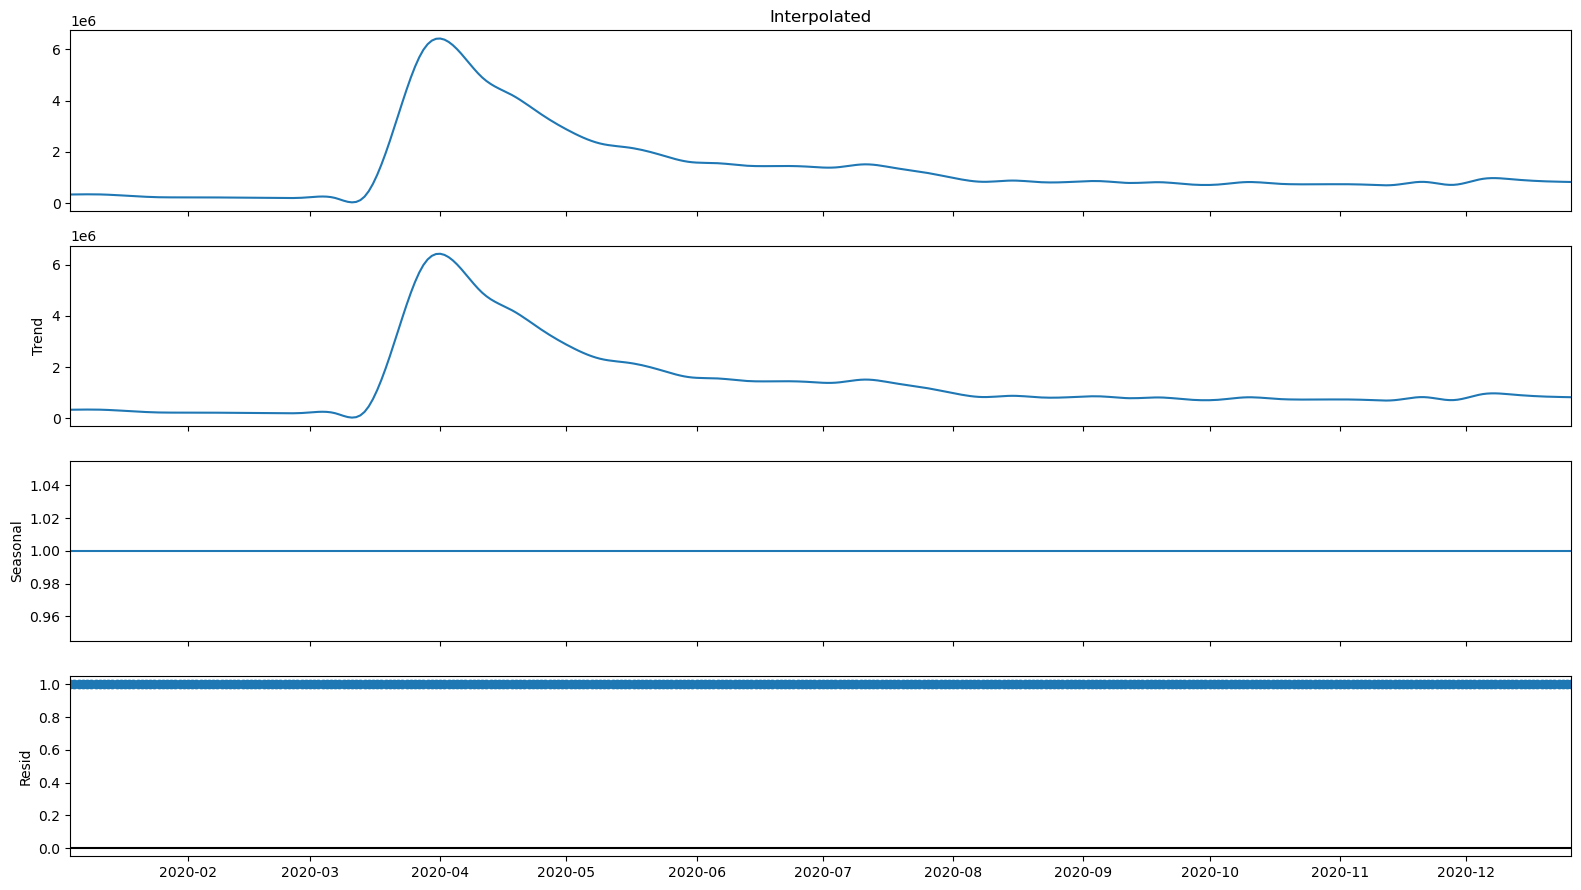

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(covid_daily['Interpolated'],period=1, model='multiplicative')
fig = result.plot();
fig.set_size_inches((16, 9))
fig.tight_layout()

Splitting into train test

In [41]:
train = covid_daily.iloc[:298]
test = covid_daily.iloc[298:]
len(test)

60

fitting multiplicative holt winters model

In [43]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
multiplicative_model = ExponentialSmoothing(train['Interpolated'],trend='mul',seasonal='mul').fit()
multiplicative_predictions = multiplicative_model.forecast(60).rename('Multiplicative HW Forecast')
multiplicative_predictions

2020-10-28    733636.670485
2020-10-29    734110.131073
2020-10-30    734333.733313
2020-10-31    734509.140858
2020-11-01    734645.628140
2020-11-02    734712.462359
2020-11-03    735571.980310
2020-11-04    735574.156498
2020-11-05    736048.867464
2020-11-06    736273.060223
2020-11-07    736448.931008
2020-11-08    736585.778744
2020-11-09    736652.789468
2020-11-10    737514.577349
2020-11-11    737516.759285
2020-11-12    737992.723931
2020-11-13    738217.508768
2020-11-14    738393.844015
2020-11-15    738531.053158
2020-11-16    738598.240852
2020-11-17    739462.304659
2020-11-18    739464.492356
2020-11-19    739941.713994
2020-11-20    740167.092472
2020-11-21    740343.893410
2020-11-22    740481.464913
2020-11-23    740548.830046
2020-11-24    741415.175787
2020-11-25    741417.369263
2020-11-26    741895.851211
2020-11-27    742121.824899
2020-11-28    742299.092757
2020-11-29    742437.027576
2020-11-30    742504.570616
2020-12-01    743373.204320
2020-12-02    743375

fitting additive holt winters model

In [45]:
additive_model = ExponentialSmoothing(train['Interpolated'],trend='add',seasonal='add').fit()
additive_predictions = additive_model.forecast(60).rename('Additive HW Forecast')
additive_predictions

2020-10-28    734432.544434
2020-10-29    735183.214026
2020-10-30    735947.527714
2020-10-31    736638.107216
2020-11-01    737424.521647
2020-11-02    738043.357440
2020-11-03    738893.406245
2020-11-04    739694.251243
2020-11-05    740444.920835
2020-11-06    741209.234522
2020-11-07    741899.814025
2020-11-08    742686.228455
2020-11-09    743305.064249
2020-11-10    744155.113054
2020-11-11    744955.958051
2020-11-12    745706.627643
2020-11-13    746470.941331
2020-11-14    747161.520833
2020-11-15    747947.935264
2020-11-16    748566.771058
2020-11-17    749416.819862
2020-11-18    750217.664860
2020-11-19    750968.334452
2020-11-20    751732.648140
2020-11-21    752423.227642
2020-11-22    753209.642073
2020-11-23    753828.477866
2020-11-24    754678.526671
2020-11-25    755479.371669
2020-11-26    756230.041261
2020-11-27    756994.354948
2020-11-28    757684.934450
2020-11-29    758471.348881
2020-11-30    759090.184675
2020-12-01    759940.233479
2020-12-02    760741

<Axes: xlabel='DATE'>

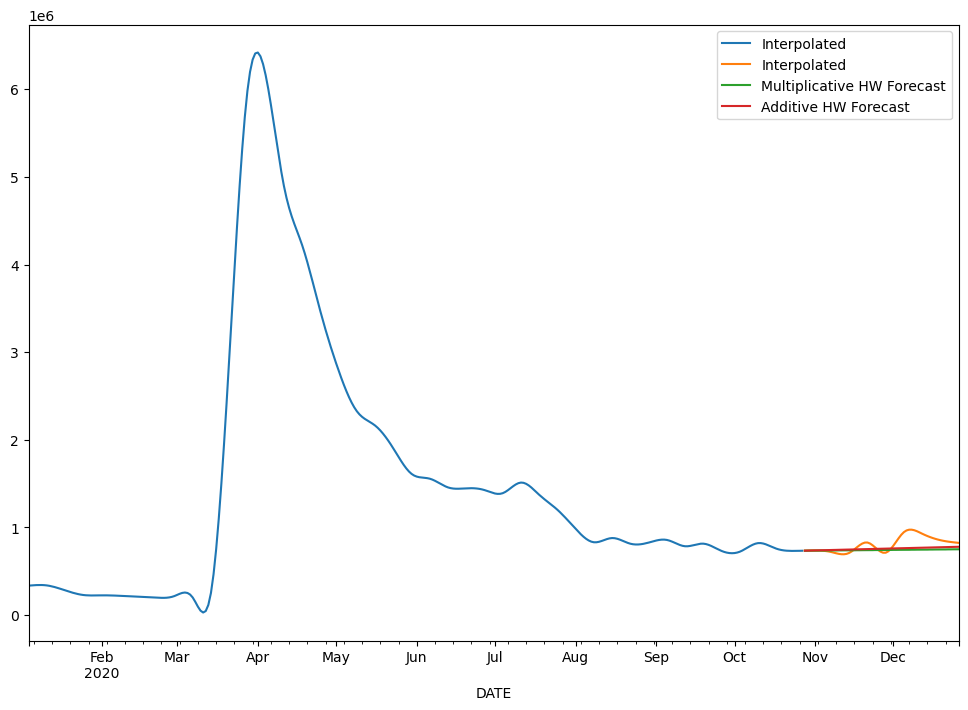

In [46]:
train['Interpolated'].plot(figsize=(12,8),legend=True)
test['Interpolated'].plot(legend=True)
multiplicative_predictions.plot(legend=True)
additive_predictions.plot(legend=True)

# Evaluation using RMSE

In [47]:
# evaluating using rmse
from sklearn.metrics import mean_squared_error
rmse_additive = np.sqrt(mean_squared_error(test['Interpolated'],additive_predictions))
rmse_multiplicative = np.sqrt(mean_squared_error(test['Interpolated'],multiplicative_predictions))
print("RMSE Of Additive model ",rmse_additive)
print("RMSE Of Multiplicative model ",rmse_multiplicative)

RMSE Of Additive model  90962.30392543114
RMSE Of Multiplicative model  103786.54206167898


# Forecasting

In [48]:
# forecasting for future dates using addditive and multiplicative model
add_model = ExponentialSmoothing(covid_daily['Interpolated'],trend='add',seasonal='add').fit()
add_forecast = add_model.forecast(60).rename('Additive HW Forecast')
mul_model = ExponentialSmoothing(covid_daily['Interpolated'],trend='add',seasonal='add').fit()
mul_forecast = mul_model.forecast(60).rename('Multiplicative HW Forecast')

<Axes: xlabel='DATE'>

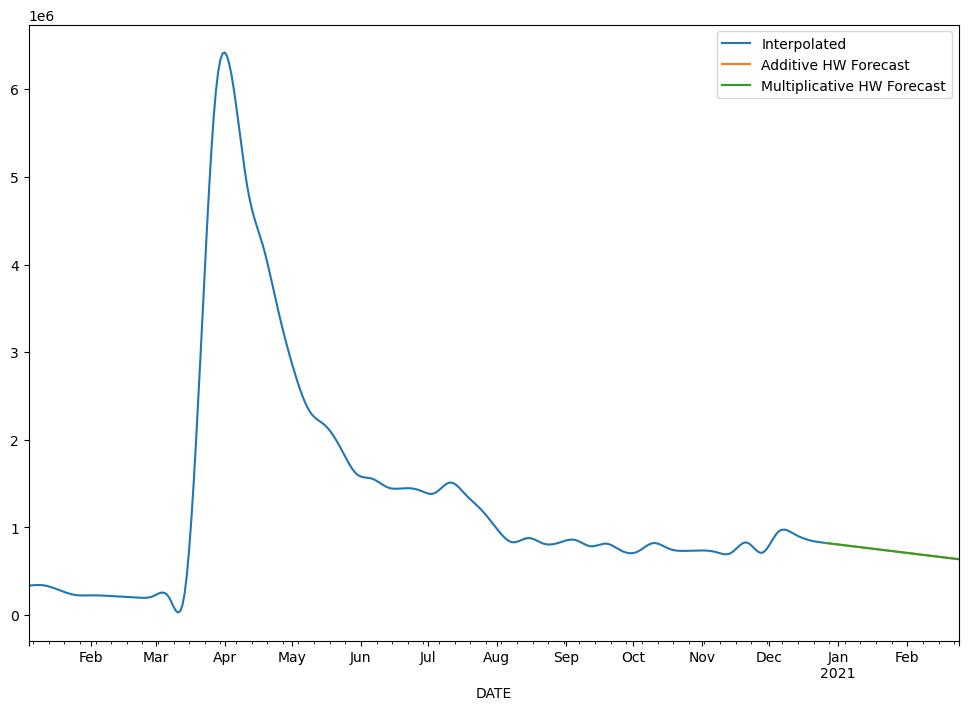

In [49]:
covid_daily['Interpolated'].plot(figsize=(12,8),legend=True)
add_forecast.plot(legend=True)
mul_forecast.plot(legend=True)

In [50]:
# check for the nearest forecasted value
covid_daily.tail()

,ICNSA,Interpolated
DATE,,
2020-12-22,NaN,837679.569657
2020-12-23,NaN,833609.699688
2020-12-24,NaN,829992.381909
2020-12-25,NaN,826676.765590
2020-12-26,823512.0,823512.000000


In [52]:
df.loc[:'2021-01-10'].tail()

,ICNSA
DATE,
2020-12-12,928178
2020-12-19,854113
2020-12-26,823512
2021-01-02,898597
2021-01-09,1082696


# 

In [56]:
# so we can check for '2021-01-02'
print("Original value for 2021-01-02 : ",df.loc['2021-01-02'].ICNSA)
# forecasted value for 2021-01-02 using additive model
print("Forecasted value by additive model for 2021-01-02 : ",add_forecast['2021-01-02'])
print("Error value by additive model for 2021-01-02 : ",df.loc['2021-01-02'].ICNSA-add_forecast['2021-01-02'])
# forecasted value for 2021-01-02 using multiplicative model
print("Forecasted value by multiplicative model for 2021-01-02 : ",mul_forecast['2021-01-02'])
print("Error value by multiplicative model for 2021-01-02 : ",df.loc['2021-01-02'].ICNSA-mul_forecast['2021-01-02'])

Original value for 2021-01-02 :  898597
Forecasted value by additive model for 2021-01-02 :  801753.6252438694
Error value by additive model for 2021-01-02 :  96843.37475613062
Forecasted value by multiplicative model for 2021-01-02 :  801753.6252438694
Error value by multiplicative model for 2021-01-02 :  96843.37475613062
